Deep learning is a powerful machine learning technique that allows for nonlinear mappings between a given input and output. As a label, "deep learning" refers to neural networks with more than one hidden layer, but it is otherwise vague in terms of its specificity.

In this lecture, we're going to work up from the basics neural networks, into a simple example, and then adding some depth to examine the effect of adding layers to a neural network. The programming language that we will be working with is Julia. This choice is motivated in part by how it allows sophisticated mathematical concepts to be represented easily in the code, and also by how it can compile down to very performant code. I have tried to make the code examples clear to read, so even if you haven't seen Julia code before, you should be able to follow along anyway. As well, the concepts discussed here will be transferable to other deep learning frameworks, such as Keras for Python or R, PyTorch, Knet.jl, and MATLAB.

To run this code on your own computer (and not within Binder in your browser), [you will need to have Julia installed](https://julialang.org/downloads/). You will also need to install the packages that are loaded in at the start of the code, principally among them the `Flux` package. To do so, open Julia, then press the `]` key, and then type `add Flux` and press `Enter`. The built-in package manager will handle the installation and all dependencies. For plotting, type `add Plots` and press `Enter`. And, if you have a GPU available and would like to use it to accelerate the neural network, type `add CuArrays` and press `Enter`. Each of the arrays used will need to be converted to a `CuArray`, which can be performed, for example, using Flux's `gpu()` function. The full list of required packages is:

* Flux
* Plots
* ProgressBars
* Random
* Statistics
* IJulia

The `IJulia` package is only necessary to be able to use this Jupyter notebook locally.

Then press the `Backspace` key to return to the regular Julia prompt. We can now begin by setting up the initial state for our work.

# What is a(n artificial) neural network?

* Simply (reductively...) a series of **weight** matrices (like slopes in linear regression) and nonlinear functions that are applied sequentially to data to create a nonlinear mapping; may also have **bias** units (which act like intercepts from linear regression)
* Origins in modeling neurons (Rosenblatt, 1958)
* Historically conceptualized in a variety of ways (accessibly summarized in Colah, 2015)
    * Neuroscientific interpretation: computational simulation of neurons
    * Representational interpretation: series of changes to representation of data, with each subsequent change bringing the data closer to the desired output
    * Probabalistic interpretation: series of learned latent features
* Recently, conceptualized as a specific kind of program that can be trained to minimize some sort of loss function (as explained in Innes, 2019 and Innes et al., 2019)
* We'll be using that more recent conceptualization
* Think about a neural network as a complex, learned **function** that **maps from some input** (e.g., acoustic data) **to some output** (e.g., acoustic segments, semantics, etc.)

Let's look at a simple example before going any further. We will train a network to learn a sine function. Please note that progress bars are only half-supported in Jupyter, so the update to the progress bars will happen with new lines, rather than as an actual updating bar.

In [1]:
using Flux
using Plots
using ProgressBars
using Random

Random.seed!(9)

Xs = randn(10000)
Ys = sin.(Xs) .+ randn(10000) ./ 100

Xs = [[x] for x in Xs]
Ys = [[y] for y in Ys]

net = Chain(Dense(1, 50, relu),
           Dense(50, 1))

p = Flux.params(net)
opt = ADAM()
d = collect(zip(Xs, Ys))

loss(x, y) = Flux.mse(net(x), y)

sortedIndices = sortperm([x[1] for x in Xs])

Yhats_epoch0 = net.(Xs[sortedIndices])

@info "EPOCH 1"
Flux.train!(loss, p, ProgressBar(d), opt)
println()

Yhats_epoch1 = net.(Xs[sortedIndices])

for epochI in 2:5
    @info "EPOCH $(epochI)"
    Flux.train!(loss, p, ProgressBar(d), opt)
    println()
end

Yhats_epoch5 = net.(Xs[sortedIndices])

[ Info: EPOCH 1
0.0%┣                                           ┫ 0/10.0k [00:00<-8:-20, -0s/it]
0.0%┣                                        ┫ 1/10.0k [00:41<Inf:Inf, InfGs/it]
5.9%┣██▌                                       ┫ 593/10.0k [00:41<10:48, 15it/s]
13.6%┣█████▍                                  ┫ 1.4k/10.0k [00:41<04:20, 33it/s]
21.2%┣████████▌                               ┫ 2.1k/10.0k [00:41<02:32, 52it/s]
29.1%┣███████████▋                            ┫ 2.9k/10.0k [00:41<01:40, 71it/s]
31.8%┣████████████▊                           ┫ 3.2k/10.0k [00:41<01:28, 78it/s]
40.3%┣████████████████▏                       ┫ 4.0k/10.0k [00:41<01:01, 98it/s]
47.5%┣██████████████████▌                    ┫ 4.7k/10.0k [00:41<00:46, 115it/s]
54.8%┣█████████████████████▍                 ┫ 5.5k/10.0k [00:41<00:34, 133it/s]
63.1%┣████████████████████████▋              ┫ 6.3k/10.0k [00:41<00:24, 153it/s]
71.5%┣████████████████████████████           ┫ 7.2k/10.0k [00:41<00:16, 173it/s]
77.1%┣██████

[ Info: EPOCH 2
0.0%┣                                           ┫ 0/10.0k [00:00<-8:-20, -0s/it]
0.0%┣                                        ┫ 1/10.0k [00:00<Inf:Inf, InfGs/it]
4.1%┣█▋                                      ┫ 412/10.0k [00:00<00:04, 2.2kit/s]
11.4%┣████▎                                 ┫ 1.1k/10.0k [00:00<00:02, 4.8kit/s]
18.0%┣██████▉                               ┫ 1.8k/10.0k [00:00<00:01, 6.3kit/s]
25.0%┣█████████▌                            ┫ 2.5k/10.0k [00:00<00:01, 7.4kit/s]
32.3%┣████████████▎                         ┫ 3.2k/10.0k [00:00<00:01, 8.3kit/s]
39.3%┣███████████████                       ┫ 3.9k/10.0k [00:00<00:01, 8.9kit/s]
46.5%┣█████████████████▊                    ┫ 4.7k/10.0k [00:00<00:01, 9.5kit/s]
53.8%┣████████████████████▍                 ┫ 5.4k/10.0k [00:01<00:00, 9.9kit/s]
59.7%┣██████████████████████               ┫ 6.0k/10.0k [00:01<00:00, 10.1kit/s]
64.9%┣████████████████████████             ┫ 6.5k/10.0k [00:01<00:00, 10.0kit/s]
71.1%┣██████

98.5%┣████████████████████████████████████▍┫ 9.8k/10.0k [00:01<00:00, 10.5kit/s]
100.0%┣███████████████████████████████████┫ 10.0k/10.0k [00:01<00:00, 10.5kit/s]
[ Info: EPOCH 3
0.0%┣                                           ┫ 0/10.0k [00:00<-8:-20, -0s/it]
0.0%┣                                        ┫ 1/10.0k [00:00<Inf:Inf, InfGs/it]
6.4%┣██▋                                     ┫ 640/10.0k [00:00<00:01, 6.3kit/s]
13.7%┣█████▏                                ┫ 1.4k/10.0k [00:00<00:01, 8.9kit/s]
20.3%┣███████▊                              ┫ 2.0k/10.0k [00:00<00:01, 9.9kit/s]
27.0%┣██████████                           ┫ 2.7k/10.0k [00:00<00:01, 10.5kit/s]
32.5%┣████████████                         ┫ 3.2k/10.0k [00:00<00:01, 10.5kit/s]
38.0%┣██████████████                       ┫ 3.8k/10.0k [00:00<00:01, 10.6kit/s]
46.0%┣█████████████████                    ┫ 4.6k/10.0k [00:00<00:00, 11.2kit/s]
54.1%┣████████████████████                 ┫ 5.4k/10.0k [00:00<00:00, 11.7kit/s]
60.5%┣██████

89.6%┣█████████████████████████████████▏   ┫ 9.0k/10.0k [00:01<00:00, 11.4kit/s]
96.8%┣███████████████████████████████████▉ ┫ 9.7k/10.0k [00:01<00:00, 11.6kit/s]
100.0%┣███████████████████████████████████┫ 10.0k/10.0k [00:01<00:00, 11.6kit/s]
[ Info: EPOCH 4
0.0%┣                                           ┫ 0/10.0k [00:00<-8:-20, -0s/it]
0.0%┣                                        ┫ 1/10.0k [00:00<Inf:Inf, InfGs/it]
6.9%┣██▊                                     ┫ 686/10.0k [00:00<00:01, 6.8kit/s]
12.3%┣████▋                                 ┫ 1.2k/10.0k [00:00<00:01, 8.0kit/s]
19.2%┣███████▎                              ┫ 1.9k/10.0k [00:00<00:01, 9.4kit/s]
26.4%┣█████████▊                           ┫ 2.6k/10.0k [00:00<00:01, 10.3kit/s]
33.2%┣████████████▎                        ┫ 3.3k/10.0k [00:00<00:01, 10.8kit/s]
38.9%┣██████████████▍                      ┫ 3.9k/10.0k [00:00<00:01, 10.8kit/s]
41.9%┣████████████████                      ┫ 4.2k/10.0k [00:00<00:01, 9.5kit/s]
49.4%┣██████


98.8%┣████████████████████████████████████▋┫ 9.9k/10.0k [00:01<00:00, 11.5kit/s]
100.0%┣███████████████████████████████████┫ 10.0k/10.0k [00:01<00:00, 11.5kit/s]
[ Info: EPOCH 5
0.0%┣                                           ┫ 0/10.0k [00:00<-8:-20, -0s/it]
0.0%┣                                        ┫ 1/10.0k [00:00<Inf:Inf, InfGs/it]
5.7%┣██▎                                     ┫ 568/10.0k [00:00<00:02, 5.5kit/s]
12.2%┣████▋                                 ┫ 1.2k/10.0k [00:00<00:01, 7.9kit/s]
18.6%┣███████                               ┫ 1.9k/10.0k [00:00<00:01, 9.0kit/s]
21.2%┣████████                              ┫ 2.1k/10.0k [00:00<00:01, 7.7kit/s]
28.0%┣██████████▋                           ┫ 2.8k/10.0k [00:00<00:01, 8.5kit/s]
34.7%┣█████████████▏                        ┫ 3.5k/10.0k [00:00<00:01, 9.1kit/s]
39.0%┣██████████████▉                       ┫ 3.9k/10.0k [00:00<00:01, 9.0kit/s]
44.8%┣█████████████████                     ┫ 4.5k/10.0k [00:00<00:01, 9.3kit/s]
51.7%┣█████

95.6%┣███████████████████████████████████▍ ┫ 9.6k/10.0k [00:01<00:00, 10.7kit/s]
100.0%┣███████████████████████████████████┫ 10.0k/10.0k [00:01<00:00, 10.6kit/s]


10000-element Vector{Vector{Float64}}:
 [0.23595449019696102]
 [-0.07407530178098076]
 [-0.07989158657042345]
 [-0.11103497427522216]
 [-0.11456851690145439]
 [-0.13210632818913903]
 [-0.16286415500423582]
 [-0.174383661980602]
 [-0.17484343701347305]
 [-0.18465236718961778]
 [-0.20597428656000302]
 [-0.22335710931401342]
 [-0.2365546033689816]
 ⋮
 [0.16639916815377326]
 [0.12327857070588209]
 [0.11423317386376287]
 [0.091867670297272]
 [0.051911966404367134]
 [0.025887795828920573]
 [0.010344024849931913]
 [0.004155426545842989]
 [-0.00943141359323077]
 [-0.017722213328144977]
 [-0.040798161822901094]
 [-0.10267573134855262]

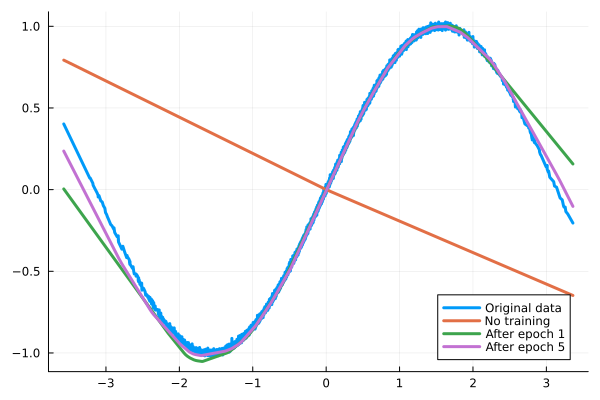

In [2]:
plot([x[1] for x in Xs[sortedIndices]], [y[1] for y in Ys[sortedIndices]], linewidth=3, label="Original data")
plot!([x[1] for x in Xs[sortedIndices]], [y[1] for y in Yhats_epoch0], linewidth=3, label="No training")
plot!([x[1] for x in Xs[sortedIndices]], [y[1] for y in Yhats_epoch1], linewidth=3, label="After epoch 1")
plot!([x[1] for x in Xs[sortedIndices]], [y[1] for y in Yhats_epoch5], linewidth=3, label="After epoch 5")

In learning the sine function, we can see the learned function beginning to converge by epoch 5. Note how the network learned a smooth representation of the data, rather than the underlying noise. For more complex problems, it may not learn the smooth representation and instead fit all the nosie as well. There are techniques like dropout that are designed to handle overfitting, but those are outside the scope of this lecture. More information on dropout can be found in resources such as Chollet (2017), and further techniques such as regularization can be found in Goodfellow, Bengio, & Courville (2016, pp. 224-270).

Note as well that this function was reasonable to visualize because there was one input and one output. Once problems grow to be more complex and have multiple inputs and outputs, it becomes considerably less obvious how to visualize the results of a neural network.

Try playing around with the network.

* What happens if you remove `relu` from it?
* What if you make the y values x^2, with `Xs.^2 .+ randn(10000) ./ 100`?
* How about `Xs.^3 .+ randn(10000) ./ 100`?
* Try something more complex like this:

```julia
f(x) = x > 2 ? x^2 : sin(x)
Ys = f.(Xs) .+ randn(10000) ./ 100
```

## Some results of modifying the network

Removing the relu from the network removes its ability to learn nonlinear functions. The reason neural networks can learn nonlinear functions is because they have a large number of simple nonlinear units that work in concert with each other. Indeed, there have been mathematical proofs that any sufficiently large number of these kinds of units can approximate any smooth mathematical function on a given interval (Cybenko, 1989). However, functions that are not smooth, like the `f(x) = x > 2 ? x^2 : sin(x)` (which can be read as $x^2$ if $x > 2$, else $\sin{x}$), are not necessarily approximable using standard neural network approaches. Visualizing the current network trying to learn this function shows this.

# Basic layer types

In the code, we specified two different `dense` or `fully-connected` layers using the `Dense()` function. This is an example of one of the three main types of layers used when creating a neural network. Each layer has a number of input nodes/neurons and a number of output nodes.

**Dense layers**

Dense layers connect every input node to every output node. These are your "bread-and-butter" layers, for all intents and purposes. Each neuron/unit in a dense layer takes a weighted sum of its inputs, possibly adds a bias value (like an intercept in linear regression).

![Fully-connected or dense neural network layers.](fully-connected.png)

Image attribution: Glosser.ca [CC BY-SA 3.0 (https://creativecommons.org/licenses/by-sa/3.0)]

**Recurrent layers**

Recurrent layers are similar to dense layers, but they also feed their output back into themselves as input. Because they are connected to themselves, they can have a certain sort of memory and can learn temporal patterns. Natural language processing systems and speech recognition systems both use this type of layer very commonly, e.g., Graves & Schmidhuber (2005) and Graves et al. (2014).

![Recurrent neural network layer](recurrent.png)

Image attribution: François Deloche [CC BY-SA 4.0 (https://creativecommons.org/licenses/by-sa/4.0)]

The most common type is the long short-term memory (LSTM) layer, though gated recurrence unit (GRU) layers are also used. These layers have extra features that allow them to learn sequential/temporal patterns more easily than a simple recurrent layer, and are thus more popuplar than simple recurrent layers.

**Convolutional layers**

A convolutional layer only connects some inputs to some outputs. These are layers are used to learn some sort of feature set from the data, such as a corner, an eye or a nose in an image. We will not be using these types of layers in the present lecture, though they have been used in a variety of speech recognition systems like in Zhang et al. (2016).

![Convolutional neural network layer visualization](convolutional.png)

Image attribution: Aphex34 [CC BY-SA 4.0 (https://creativecommons.org/licenses/by-sa/4.0)]

**Activation layers**

This a layer that applies a single function (usually, though not necessarily, static) over all its input. When the function is not linear, it allows the neural network to learn a nonlinear relationship in the data. Currently, the rectified linear unit (ReLU) is the go-to choice. Historically, functions like the sigmoid and hyperbolic tangent were used. At the end of a network that is being used for classification, a softmax function is usually used, which scales the input so that they sum to 1 (like a probability distribution).

Activation layers are not always considered separate from other layers. Some treatments of neural networks treat them as an integral part of dense, convolutional, or recurrent layers. Most modern frameworks allow you to use either treatment by either specifying the activation as a subpart of a layer or else by adding it as a separate layer. In Julia, for example, `Chain(Dense(5, 5, relu))` and `Chain(Dense(5, 5), relu)` are equivalent.

![Rectified linear unit example](relu.png)

Image Attribution: Dan Stowell [CC0 1.0 (https://creativecommons.org/publicdomain/zero/1.0/)]

(Ignore the green softplus plot.)

# Why use a deep neural network for modeling?

* The promise of deep neural networks is that they can learn abstract mappings from more "raw" data (Goodfellow, Bengio, & Courville, 2016, pp. 3-5)
* As such, it is not necessary to know what sort of intermediate steps there are when mapping from some input to some output
* E.g., in speech recognition, mappings are made from acoustic data to phonemes (Graves & Schmidhuber, 2005) or orthographic letters (Graves & Jaitly, 2014)
    * Not much is known on the exact computational steps needed to map from the acoustics to the abstract outputs
    * Instead, the deep neural network learns an "optimal" way to recognize phonemes or letters

# Challenges when using deep neural networks for modeling

* It is difficult to extract what they've learned from their parameters
* They can be difficult to train
* Learning from more "raw" data usually requires more data than learning from a more processed representation
* Rare that a neural network converges in quite the same way as a linear mixed-effects regression model
* Complete convergence on a global minimum is often undesirable because it usually means the network has overfit and won't generalize well

# More complex networks (becoming deep)

Let's try working with more complex (deeper) networks. To start, let's see how fast the network learns the sine function from before if it has another layer.

In [3]:
net = Chain(Dense(1, 50, relu),
            Dense(50, 25, relu),
           Dense(25, 1))

p = Flux.params(net)
opt = ADAM()
d = collect(zip(Xs, Ys))

loss(x, y) = Flux.mse(net(x), y)

sortedIndices = sortperm([x[1] for x in Xs])

Yhats_epoch0_2 = net.(Xs[sortedIndices])

@info "EPOCH 1"
Flux.train!(loss, p, ProgressBar(d), opt)
println()

Yhats_epoch1_2 = net.(Xs[sortedIndices])

for epochI in 2:5
    @info "EPOCH $(epochI)"
    Flux.train!(loss, p, ProgressBar(d), opt)
    println()
end

Yhats_epoch5_2 = net.(Xs[sortedIndices])

[ Info: EPOCH 1
0.0%┣                                           ┫ 0/10.0k [00:00<-8:-20, -0s/it]
0.0%┣                                        ┫ 1/10.0k [00:01<Inf:Inf, InfGs/it]
4.0%┣█▋                                       ┫ 399/10.0k [00:01<00:34, 283it/s]
7.0%┣██▉                                      ┫ 699/10.0k [00:01<00:19, 478it/s]
8.0%┣███▎                                     ┫ 802/10.0k [00:02<00:17, 529it/s]
8.9%┣███▋                                     ┫ 890/10.0k [00:02<00:16, 566it/s]
9.7%┣████                                     ┫ 973/10.0k [00:02<00:15, 592it/s]
9.8%┣████                                     ┫ 984/10.0k [00:02<00:16, 577it/s]
10.0%┣████                                    ┫ 998/10.0k [00:02<00:16, 566it/s]
10.5%┣████                                   ┫ 1.0k/10.0k [00:02<00:16, 577it/s]
12.7%┣█████                                  ┫ 1.3k/10.0k [00:02<00:13, 679it/s]
14.6%┣█████▊                                 ┫ 1.5k/10.0k [00:02<00:11, 763it/s]
14.9%┣█████▉

[ Info: EPOCH 2
0.0%┣                                           ┫ 0/10.0k [00:00<-8:-20, -0s/it]
0.0%┣                                        ┫ 1/10.0k [00:00<Inf:Inf, InfGs/it]
3.9%┣█▌                                      ┫ 386/10.0k [00:00<00:03, 3.8kit/s]
6.9%┣██▊                                     ┫ 693/10.0k [00:00<00:02, 4.5kit/s]
9.6%┣███▉                                    ┫ 959/10.0k [00:00<00:02, 4.7kit/s]
12.3%┣████▊                                 ┫ 1.2k/10.0k [00:00<00:02, 4.8kit/s]
14.5%┣█████▌                                ┫ 1.4k/10.0k [00:00<00:02, 4.7kit/s]
16.6%┣██████▎                               ┫ 1.7k/10.0k [00:00<00:02, 4.6kit/s]
17.3%┣██████▋                               ┫ 1.7k/10.0k [00:00<00:02, 4.0kit/s]
20.2%┣███████▋                              ┫ 2.0k/10.0k [00:00<00:02, 4.2kit/s]
22.6%┣████████▋                             ┫ 2.3k/10.0k [00:01<00:02, 4.2kit/s]
25.2%┣█████████▋                            ┫ 2.5k/10.0k [00:01<00:02, 4.3kit/s]
27.3%┣██████


96.7%┣████████████████████████████████████▊ ┫ 9.7k/10.0k [00:02<00:00, 4.5kit/s]
98.8%┣█████████████████████████████████████▌┫ 9.9k/10.0k [00:02<00:00, 4.4kit/s]
100.0%┣████████████████████████████████████┫ 10.0k/10.0k [00:02<00:00, 4.4kit/s]
[ Info: EPOCH 3
0.0%┣                                           ┫ 0/10.0k [00:00<-8:-20, -0s/it]
0.0%┣                                        ┫ 1/10.0k [00:00<Inf:Inf, InfGs/it]
2.5%┣█                                       ┫ 254/10.0k [00:00<00:04, 2.5kit/s]
4.8%┣██                                      ┫ 482/10.0k [00:00<00:03, 3.1kit/s]
7.3%┣███                                     ┫ 729/10.0k [00:00<00:03, 3.6kit/s]
9.6%┣███▉                                    ┫ 961/10.0k [00:00<00:02, 3.7kit/s]
11.6%┣████▍                                 ┫ 1.2k/10.0k [00:00<00:02, 3.8kit/s]
13.6%┣█████▏                                ┫ 1.4k/10.0k [00:00<00:02, 3.8kit/s]
15.3%┣█████▉                                ┫ 1.5k/10.0k [00:00<00:02, 3.7kit/s]
17.1%┣█████


97.2%┣█████████████████████████████████████ ┫ 9.7k/10.0k [00:02<00:00, 4.4kit/s]
98.6%┣█████████████████████████████████████▌┫ 9.9k/10.0k [00:02<00:00, 4.3kit/s]
100.0%┣████████████████████████████████████┫ 10.0k/10.0k [00:02<00:00, 4.3kit/s]
[ Info: EPOCH 4
0.0%┣                                           ┫ 0/10.0k [00:00<-8:-20, -0s/it]
0.0%┣                                        ┫ 1/10.0k [00:00<Inf:Inf, InfGs/it]
2.3%┣█                                       ┫ 232/10.0k [00:00<00:04, 2.3kit/s]
4.3%┣█▊                                      ┫ 426/10.0k [00:00<00:03, 2.8kit/s]
6.5%┣██▋                                     ┫ 653/10.0k [00:00<00:03, 3.2kit/s]
8.7%┣███▌                                    ┫ 872/10.0k [00:00<00:03, 3.4kit/s]
11.2%┣████▎                                 ┫ 1.1k/10.0k [00:00<00:02, 3.6kit/s]
13.7%┣█████▏                                ┫ 1.4k/10.0k [00:00<00:02, 3.8kit/s]
15.9%┣██████                                ┫ 1.6k/10.0k [00:00<00:02, 3.8kit/s]
18.7%┣█████

97.6%┣█████████████████████████████████████ ┫ 9.8k/10.0k [00:02<00:00, 4.2kit/s]
99.2%┣█████████████████████████████████████▊┫ 9.9k/10.0k [00:02<00:00, 4.2kit/s]
100.0%┣████████████████████████████████████┫ 10.0k/10.0k [00:02<00:00, 4.2kit/s]
[ Info: EPOCH 5
0.0%┣                                           ┫ 0/10.0k [00:00<-8:-20, -0s/it]
0.0%┣                                        ┫ 1/10.0k [00:00<Inf:Inf, InfGs/it]
2.1%┣▉                                       ┫ 210/10.0k [00:00<00:05, 2.0kit/s]
4.4%┣█▊                                      ┫ 436/10.0k [00:00<00:03, 2.8kit/s]
6.6%┣██▋                                     ┫ 659/10.0k [00:00<00:03, 3.2kit/s]
9.1%┣███▋                                    ┫ 914/10.0k [00:00<00:03, 3.5kit/s]
11.4%┣████▍                                 ┫ 1.1k/10.0k [00:00<00:02, 3.6kit/s]
13.8%┣█████▎                                ┫ 1.4k/10.0k [00:00<00:02, 3.8kit/s]
15.8%┣██████                                ┫ 1.6k/10.0k [00:00<00:02, 3.8kit/s]
17.8%┣██████

99.0%┣█████████████████████████████████████▋┫ 9.9k/10.0k [00:03<00:00, 3.6kit/s]
100.0%┣████████████████████████████████████┫ 10.0k/10.0k [00:03<00:00, 3.6kit/s]


10000-element Vector{Vector{Float64}}:
 [0.20466116504916854]
 [-0.07309237036934153]
 [-0.07812018710762385]
 [-0.10504171032347698]
 [-0.10809623832627535]
 [-0.12325658626953723]
 [-0.14984481605753272]
 [-0.1598027139406728]
 [-0.16020016088314518]
 [-0.16867937142898667]
 [-0.18711084564037878]
 [-0.20213721562828618]
 [-0.21357269732460082]
 ⋮
 [0.12979592649884908]
 [0.08483081128338438]
 [0.07539991450242882]
 [0.0520815513392691]
 [0.011605791329431847]
 [-0.013153848709609256]
 [-0.027942338247568435]
 [-0.0338302287342693]
 [-0.04675687591159974]
 [-0.05456670752612604]
 [-0.07425125007911616]
 [-0.1230269110777682]

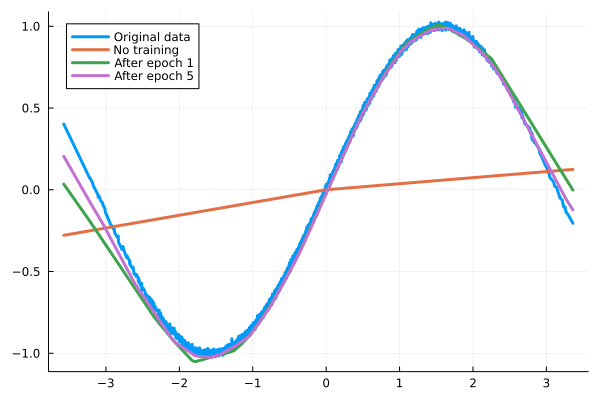

In [4]:
plot([x[1] for x in Xs[sortedIndices]], [y[1] for y in Ys[sortedIndices]], linewidth=3, label="Original data")
plot!([x[1] for x in Xs[sortedIndices]], [y[1] for y in Yhats_epoch0_2], linewidth=3, label="No training")
plot!([x[1] for x in Xs[sortedIndices]], [y[1] for y in Yhats_epoch1_2], linewidth=3, label="After epoch 1")
plot!([x[1] for x in Xs[sortedIndices]], [y[1] for y in Yhats_epoch5_2], linewidth=3, label="After epoch 5")

Let's compare the first model (model 1) to the second model (model 2), after one epoch of training.

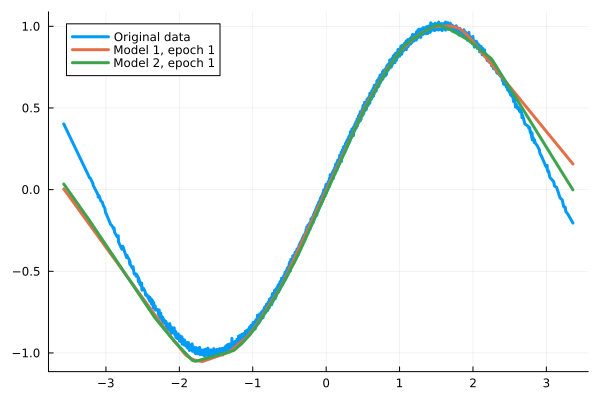

In [5]:
plot([x[1] for x in Xs[sortedIndices]], [y[1] for y in Ys[sortedIndices]], linewidth=3, label="Original data")
plot!([x[1] for x in Xs[sortedIndices]], [y[1] for y in Yhats_epoch1], linewidth=3, label="Model 1, epoch 1")
plot!([x[1] for x in Xs[sortedIndices]], [y[1] for y in Yhats_epoch1_2], linewidth=3, label="Model 2, epoch 1")

After the first epoch, we can see that the more complex model is a better fit to the original data. It's likely this is due to the more complex network having a greater amount of numbers to work with when learning how to map from the input to the output. See what happens when you add more layers!

# Regression and classification techniques

The networks that we've looked at so far have been performing a task called **regression**, where the overall goal of the network is to predict numbers. Neural networks for regression can be used for speech synthesis, where the audio samples need to be predicted, as in Google's WaveNet system (van den Oord et al., 2016).

Another type of task is **classification**, where the overall goal is choosing between a number of different classes of data. This technique is often used in speech recognition where the system has to determine what phoneme or grapheme class a given slice of audio belongs to (Graves & Schmidhuber, 2005; Graves & Jaitly, 2014).

# Summary

Neural networks are powerful nonlinear function approximators. Motivations for using them include that they can learn nonlinear functions and that they (crudely) model how neurons work. However, they are difficult to interpret. Just consider how even the small sample network has a hidden layer with 50 neurons that we can't easily interpret because of the nonlinear activation function.

If you would like more examples to play with, take a look at Google's [TensorFlow playground](https://playground.tensorflow.org/), which has a bunch of visual examples of both regression and classification tasks with neural networks. I also have a basic speech recognition network (which I made as part of a workshop presentation) that can be played with in one of my [GitHub repositories](https://github.com/maetshju/moproc2019_deep_learning_workshop). The intro notebook is similar to this one here, while the modeling notebook has the speech recognition example.

# References

Baayen, R. H., Chuang, Y.-Y., Shafaei-Bajestan, E., & Blevins, J. P. (2019). The Discriminative Lexicon: A Unified Computational Model for the Lexicon and Lexical Processing in Comprehension and Production Grounded Not in (De)Composition but in Linear Discriminative Learning. *Complexity*. https://doi.org/10.1155/2019/4895891

Baayen, R. H., Milin, P., Đurđević, D. F., Hendrix, P., & Marelli, M. (2011). An amorphous model for morphological processing in visual comprehension based on naive discriminative learning. *Psychological Review*, 118(3), 438–481. https://doi.org/10.1037/a0023851

Chollet, F. (2017). *Deep Learning with Python*. Shelter Island, New York, USA: Manning.

Colah, C. (2015). Neural Networks, Types, and Functional Programming. Retrieved November 1, 2019, from *Colah’s blog* website: https://colah.github.io/posts/2015-09-NN-Types-FP/

Cybenko, G. (1989). Approximation by superpositions of a sigmoidal function. Mathematics of Control, Signals and Systems, 2(4), 303–314. https://doi.org/10.1007/BF02551274

Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep Learning. Cambridge, MA, USA: MIT Press.

Graves, A., & Jaitly, N. (2014). Towards End-To-End Speech Recognition with Recurrent Neural Networks. *PMLR*, 1764–1772. Retrieved from http://proceedings.mlr.press/v32/graves14.html

Graves, A., & Schmidhuber, J. (2005). Framewise phoneme classification with bidirectional LSTM and other neural network architectures. *Neural Networks*, 18(5), 602–610. https://doi.org/10.1016/j.neunet.2005.06.042

Innes, M. (2019). Flux – What Is Differentiable Programming? Retrieved November 1, 2019, from *Flux* website: https://fluxml.ai/2019/02/07/what-is-differentiable-programming.html

Innes, M., Edelman, A., Fischer, K., Rackauckas, C., Saba, E., Shah, V. B., & Tebbutt, W. (2019). A Differentiable Programming System to Bridge Machine Learning and Scientific Computing. ArXiv:1907.07587 [Cs]. Retrieved from http://arxiv.org/abs/1907.07587

Rosenblatt, F. (1958). The perceptron: A probabilistic model for information storage and organization in the brain. *Psychological Review*, 65(6), 386–408. https://doi.org/10.1037/h0042519

Sutton, R. S., & Barto, A. G. (1981). Toward a modern theory of adaptive networks: Expectation and prediction. *Psychological Review*, 88(2), 135–170. https://doi.org/10.1037/0033-295X.88.2.135

van den Oord, A., Dieleman, S., Zen, H., Simonyan, K., Vinyals, O., Graves, A., ... & Kavukcuoglu, K. (2016). Wavenet: A generative model for raw audio. arXiv preprint arXiv:1609.03499.

Zhang, Y., Pezeshki, M., Brakel, P., Zhang, S., Laurent, C., Bengio, Y., & Courville, A. (2016). Towards End-to-End Speech Recognition with Deep Convolutional Neural Networks. 410–414. *INTERSPEECH 2016*. https://doi.org/10.21437/Interspeech.2016-1446